# Problem Set 7

In [61]:
using Pkg
Pkg.activate(@__DIR__)
# Pkg.instantiate()

# Load packages
using QuantEcon
using QuantEcon: solve
using Format
using Parameters
using ForwardDiff: gradient, hessian
using FiniteDifferences: grad, central_fdm
using Statistics: mean
using LinearAlgebra: dot, norm
using Plots
using DataFrames
using Binscatters
using Optim
using Optim: optimize, minimizer, f_calls
using TexTables
using LogExpFunctions
using ProgressMeter
using Interpolations
using LaTeXStrings
using DataFrames
using Plots
using Dierckx
using ThreadTools
using Roots

  Activating project at `~/Desktop/PNM for Economics/PNM_for_Econ_Group_1_Desktop`


## Exercise 1

In [63]:
@with_kw struct params
    β::Float64 = 0.95
    δ::Float64 = 0.05
    σ::Float64 = 2.0
    ν::Float64 = 2.0
    α::Float64 = 1/3
    A::Float64 = 1.0
    ϕ::Float64 = 1.0
    nk::Int64 = 100
    nl::Int64 = 100
end

p = params()
@unpack β, δ, σ, ν, α, A, ϕ, nk, nl = p

function u(p, c, l)
    @unpack β, δ, σ, ν, α, A, ϕ, nk = p
    return (c^(1-σ))/(1-σ) - ϕ*(l^(1+1/ν))/(1+1/ν)
end

function f(p, k, l)
    @unpack β, δ, σ, ν, α, A, ϕ, nk = p
    return A * k^α * l^(1-α)
end

mutable struct Policy
    k::Vector{Float64}
    l::Vector{Float64}
    c::Vector{Float64}
end

kgrid = LinRange(1e-12, 10, p.nk)
lgrid = range(0, 1, nl)
policy = Policy(zeros(p.nk), zeros(p.nl), zeros(p.nk))

Policy([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

### Exercise 1a

In [64]:
function update_bellman!(p, V, policy, kgrid, lgrid, V0)
    @unpack β, δ, α, A = p

    for i in 1:length(kgrid)
        k = kgrid[i]
        vmax = -Inf
        optimal_k_p = 0

        for j in eachindex(lgrid)
            l = lgrid[j]
            z = f(p, k, l) + (1 - δ) * k

            for k_p in kgrid
                c = z - k_p

                if c > 0
                    v = u(p, c, l) + β * V0[searchsortedlast(kgrid, k_p)]
                    if v > vmax
                        vmax = v
                        policy.l[i] = l
                        policy.c[i] = c
                        optimal_k_p = k_p
                    end
                end
            end
        end
        V[i] = vmax
        policy.k[i] = optimal_k_p
    end
end

function solve_vfi(p, kgrid, lgrid, V0; tol=1e-12, maxiter=1000)
    @unpack β, δ, α, A, nk, nl = p
    V = similar(V0)
    policy = (k=zeros(length(kgrid)), l=zeros(length(kgrid)), c=zeros(length(kgrid)))
    errors = Float64[]
    iter = 0
    while iter < maxiter
        iter += 1
        update_bellman!(p, V, policy, kgrid, lgrid, V0)
        
        ϵ = maximum(abs.(V .- V0))
        push!(errors, ϵ)
        
        ϵ < tol && break
        iter >= maxiter && break
        V0 .= V
    end
    return V, policy, iter, errors
end
absolute_error(X,X0) = mapreduce(max, X, X0) do x, x0
    abs(x-x0)
end

absolute_error (generic function with 1 method)

In [65]:
grid_sizes = [10, 25, 50, 75, 100, 150, 200]
anim = @animate for n in grid_sizes
    println("---------- grid size = $n ----------")
    kgrid = LinRange(1e-12, 10, n)
    lgrid = LinRange(0, 1, n)
    V0 = zeros(n)
    @time V_vfi, policy_vfi, iter_vfi, errors_vfi = solve_vfi(p, kgrid, lgrid, V0)
    println("\n")

    investment_p = plot(kgrid, policy_vfi.k, label="Investment ($n)", xlabel="Capital (k)", ylabel="\$l\$", title = "Investment Policy")
    labour_p = plot(kgrid, policy_vfi.l, label="Labour Supply ($n)", xlabel="Capital (k)", ylabel="\$l\$", title = "Labour Policy")
    consumption_p = plot(kgrid, policy_vfi.c, label="Consumption ($n)", xlabel="Capital (k)", ylabel="\$k\$", title = "Consumption Policy")

    plot(investment_p, labour_p, consumption_p)
end

# For future use
kgrid = LinRange(1e-12, 10, 100)
lgrid = LinRange(0, 1, 100)

---------- grid size = 10 ----------
  0.103204 seconds (39.55 k allocations: 2.556 MiB, 83.03% compilation time)


---------- grid size = 25 ----------
  0.239624 seconds (687 allocations: 175.344 KiB)


---------- grid size = 50 ----------
  1.889451 seconds (687 allocations: 332.141 KiB)


---------- grid size = 75 ----------
  6.224280 seconds (687 allocations: 447.125 KiB)


---------- grid size = 100 ----------
 14.364169 seconds (687 allocations: 593.469 KiB)


---------- grid size = 150 ----------
 48.777662 seconds (687 allocations: 896.609 KiB)


---------- grid size = 200 ----------
114.333543 seconds (687 allocations: 1.161 MiB)




┌ Info: Saved animation to /Users/arthurjohnson/Desktop/PNM for Economics/PNM_for_Econ_Group_1_Desktop/animation.gif
└ @ Plots /Users/arthurjohnson/.julia/packages/Plots/sxUvK/src/animation.jl:156


200-element LinRange{Float64, Int64}:
 0.0, 0.00502513, 0.0100503, 0.0150754, …, 0.984925, 0.98995, 0.994975, 1.0

┌ Info: Saved animation to /Users/arthurjohnson/Desktop/PNM for Economics/PNM_for_Econ_Group_1_Desktop/animation.gif
└ @ Plots /Users/arthurjohnson/.julia/packages/Plots/sxUvK/src/animation.jl:156


Plots.AnimatedGif("/Users/arthurjohnson/Desktop/PNM for Economics/PNM_for_Econ_Group_1_Desktop/animation.gif")
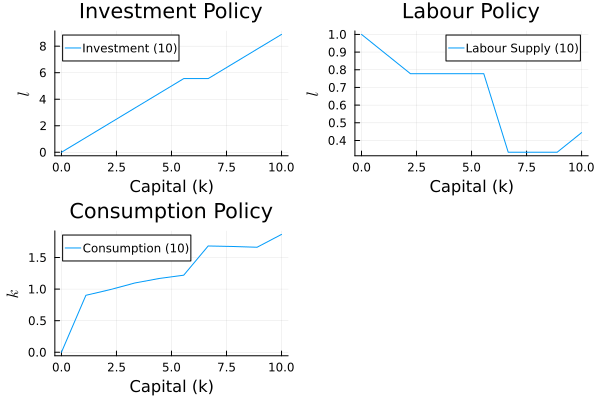

In [69]:
gif(anim, "animation.gif", fps=1)

The greater the number of grid points, the smoother the solution becomes. We can see this in the animation. Further, we also see that as the grid size increases, so too does its computation time, almost exponentially. We see that with c.75 points on the capital grid, it becomes to look smoother. We expect this to be MUCH smoother with the cubic splines used in future questions though. The solution for a capital grid of 10 takes c.0.015 seconds, while with teh capital grid equal to 200, it takes roughly 95 seconds to compute.

### Exercise 1b

In [68]:
v0 = ones(length(kgrid))
c_policy_initial = rand(length(kgrid)).*maximum(kgrid)
l_policy_initial = rand(length(kgrid))
k_policy_initial = rand(length(kgrid)).*maximum(kgrid)



function policy_iteration(v0, c_policy_initial, l_policy_initial, k_policy_initial; n_iter=1000, tol=1e-12, policy_steps_vector)
    @unpack β, δ, σ, ν, α, A, ϕ = p
    results = Dict{Int, Tuple{Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}}}()
    
    for policy_steps in policy_steps_vector
        println("------------- $policy_steps policy steps --------------")
        errors_pfi = zeros(n_iter)
        v = copy(v0)
        c_policy = copy(c_policy_initial)
        l_policy = copy(l_policy_initial)
        k_policy = copy(k_policy_initial)
        
        @time begin
            for i in 1:n_iter
                v_new = similar(v)
                for (i_k, k) in enumerate(kgrid)
                    max_val = -Inf
                    optimal_k_index = 1
                    for (i_l, l) in enumerate(lgrid)
                        for ki in optimal_k_index:length(kgrid)
                            k_p = kgrid[ki]
                            c = f(p, k, l) + (1-δ)*k - k_p
                            if c > 0
                                val = u(p, c, l) + β * v[ki]
                                if val > max_val
                                    max_val = val
                                    c_policy[i_k] = c
                                    l_policy[i_k] = l
                                    k_policy[i_k] = k_p
                                    optimal_k_index = ki
                                end
                            else
                                break
                            end
                        end
                    end
                    v_new[i_k] = max_val
                end

                for p_step in 2:policy_steps
                    for (i_k, k) in enumerate(kgrid)
                        max_val = -Inf
                        optimal_k_index = 1
                        for (i_l, l) in enumerate(lgrid)
                            for ki in optimal_k_index:length(kgrid)
                                k_p = kgrid[ki]
                                c = f(p, k, l) + (1-δ)*k - k_p
                                if c > 0
                                    val = u(p, c, l) + β * v_new[ki]
                                    if val > max_val
                                        max_val = val
                                        c_policy[i_k] = c
                                        l_policy[i_k] = l
                                        k_policy[i_k] = k_p
                                        optimal_k_index = ki
                                    end
                                else
                                    break
                                end
                            end
                        end
                        v_new[i_k] = max_val
                    end
                end

                errors_pfi[i] = maximum(abs, v_new .- v)
                dist = maximum(abs, v_new .- v)
                v .= v_new
                if dist < tol
                    errors_pfi = errors_pfi[1:i]
                    println("Converged in $i iterations with error $dist ")
                    break
                end
            end
        end
        results[policy_steps] = (c_policy, l_policy, k_policy, errors_pfi)
        println("\n")
    end

    return results
end

results = policy_iteration(v0, c_policy_initial, l_policy_initial, k_policy_initial; policy_steps_vector=[2, 5, 10])


------------- 2 policy steps --------------
Converged in 333 iterations with error 1.0658141036401503e-14 
 42.562593 seconds (962.96 M allocations: 16.144 GiB, 1.33% gc time, 0.01% compilation time)


------------- 5 policy steps --------------
Converged in 134 iterations with error 2.1316282072803006e-14 
 42.593713 seconds (968.22 M allocations: 16.232 GiB, 1.39% gc time)


------------- 10 policy steps --------------
Converged in 68 iterations with error 2.1316282072803006e-14 
 42.351858 seconds (984.37 M allocations: 16.502 GiB, 1.22% gc time)




Dict{Int64, NTuple{4, Vector{Float64}}} with 3 entries:
  5  => ([0.0001, 0.359656, 0.374645, 0.454508, 0.517057, 0.569091, 0.61394, 0.…
  2  => ([0.0001, 0.359656, 0.374645, 0.454508, 0.517057, 0.569091, 0.61394, 0.…
  10 => ([0.0001, 0.359656, 0.374645, 0.454508, 0.517057, 0.569091, 0.61394, 0.…

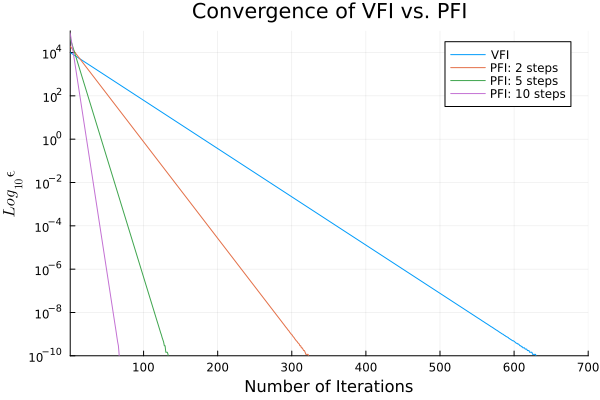

In [70]:
plt = plot()

plot!(1:length(errors_vfi), errors_vfi, yscale = :log10,
    title  = "Convergence of VFI vs. PFI",
    label  = "VFI",
    xlabel = "Number of Iterations",
    ylabel = raw"$Log_{10} ϵ$",
    yticks = 10.0.^(4:-2:-14),
    legend = :topright,
    xlims = (1, 700),
    ylims = (1e-10, 1e5)
)

for k in [2, 5, 10]
    c_policy, l_policy, k_policy, errors_pfi = results[k]
    plot!(plt, 1:length(errors_pfi), errors_pfi, label = "PFI: $k steps")
end

display(plt)

From our results, we can see that the policy function iteration drastically reduces the number of iterations required in order to converge to the answer within a given tolerance. To follow on, with a higher number of policy steps per iteration, the number of iterations required to converge reduces further. This is to be expected in the same way a chess player who can play with a greater number of steps ahead of their opponent is more likely to perform both faster and make better next moves (I have no citation for this, I am just presuming. I am sure I could find one, I just do not wish to look for one)

┌ Info: Saved animation to /Users/arthurjohnson/Desktop/PNM for Economics/PNM_for_Econ_Group_1_Desktop/animation.gif
└ @ Plots /Users/arthurjohnson/.julia/packages/Plots/sxUvK/src/animation.jl:156


Plots.AnimatedGif("/Users/arthurjohnson/Desktop/PNM for Economics/PNM_for_Econ_Group_1_Desktop/animation.gif")
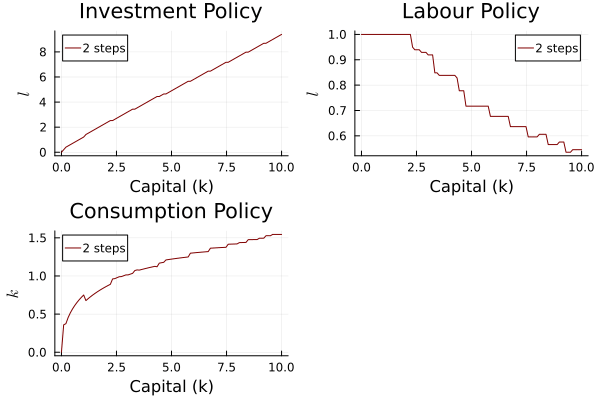

In [71]:
colours = [:maroon, :green, :black]

anim = @animate for (i, k) in enumerate([2, 5, 10])
    c_policy, l_policy, k_policy = results[k]
    
    investment_plot = plot(xlabel="Capital (k)", ylabel="\$l\$", title = "Investment Policy")
    labour_plot = plot(xlabel="Capital (k)", ylabel="\$l\$", title = "Labour Policy")
    consumption_plot = plot(xlabel="Capital (k)", ylabel="\$k\$", title = "Consumption Policy")

    plot!(investment_plot, kgrid, k_policy, label="$k steps", linecolor=colours[i])
    plot!(labour_plot, kgrid, l_policy, label="$k steps", linecolor=colours[i])
    plot!(consumption_plot, kgrid, c_policy, label="$k steps", linecolor=colours[i])

    plot(investment_plot, labour_plot, consumption_plot, legend=true)
end

gif(anim, "animation.gif", fps=1)

As you can see, the difference in the steps does not change their convergence, though.

### Exrecise 1c

  0.118417 seconds (230.19 k allocations: 12.987 MiB, 86.58% compilation time)


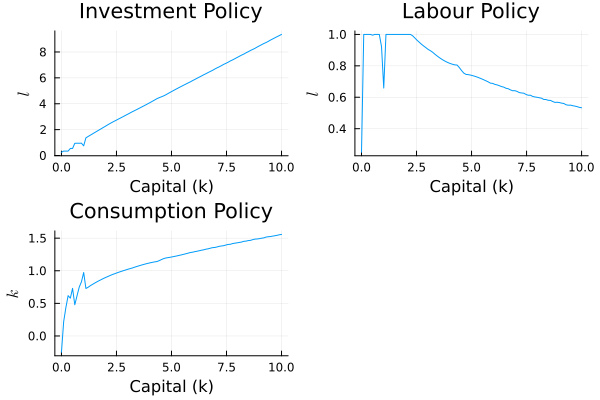

In [132]:
kgrid = LinRange(1e-12, 10, 100)
lgrid = LinRange(0, 1, 100)

function cubic_opt(p, kgrid, lgrid, V)
    @unpack β, δ, σ, ν, α, A, ϕ = p

    V_spline = CubicSplineInterpolation(kgrid, V)
    xbounded(lb, ub) = x -> max(min(x, ub), lb)
    kbd = xbounded(extrema(kgrid)...)
    k_policy = similar(kgrid)
    l_policy = similar(lgrid)
    c_policy = similar(kgrid)
    lb = [0, 1e-6]
    ub = [1, 10]


    function objective(x, k)
        l = x[1]
        k_prime = kbd(x[2])
        c_input = f(p, k, l) + (1 - δ) * k - k_prime
        c = c_input > 0 ? c_input : 1e-20
        return -(u(p, c, l) + β * V_spline(k_prime))
    end

    for (i, k) in enumerate(kgrid)
        initial_guess = [0.25, 0.25]

        result = optimize(x -> objective(x, k), lb, ub, initial_guess, Fminbox(LBFGS()))
        
        l_opt = Optim.minimizer(result)[1]
        k_prime_opt = Optim.minimizer(result)[2]
        c = f(p, k, l_opt) + (1 - δ) * k - k_prime_opt
        
        k_policy[i] = k_prime_opt
        l_policy[i] = l_opt
        c_policy[i] = c
    end

    return k_policy, l_policy, c_policy
end

@time k_policy, l_policy, c_policy = cubic_opt(p, kgrid, lgrid, V_vfi)

investment_p = plot(kgrid, k_policy, xlabel="Capital (k)", ylabel="\$l\$", title="Investment Policy")
labour_p = plot(kgrid, l_policy, xlabel="Capital (k)", ylabel="\$l\$", title="Labour Policy")
consumption_p = plot(kgrid, c_policy, xlabel="Capital (k)", ylabel="\$k\$", title="Consumption Policy")

plot(investment_p, labour_p, consumption_p, legend=false)

This is, in part, what we would expect to see for teh cubic splines. I could not get it to work properly, and I am unsure why. In an ideal output, we weould expect to see that the graphs are very smooth (with a high capital grid size) and not 'stepped' in the way we say the outputs of 1a, nor 'jolty' as we saw in 1b. Unfortunately, we still have a slightly 'jolty' output. This has varied massively dependent on us changing our guesses (even drastically when I changed it from [0.25, 0.25] to [0.245, 0.245]), capital grid sizes, etc. I do not know how to get around this, and am instead telling you that we would have expected to see a totally smooth outcome in the graphs. This will have knock-on effects in both d and e I imagine.


We can, however, see that it is much, much faster.

### Exercise 1d

Steady state level of investment: 4.523458639183073


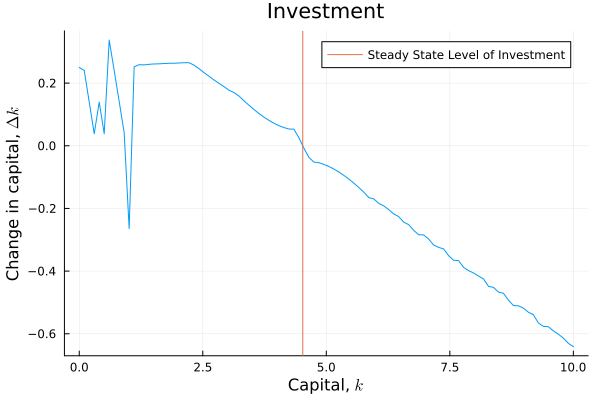

In [114]:
using Interpolations

kgrid1 = LinRange(1e-12, 10, 100)
k_interp  = CubicSplineInterpolation(kgrid, k_policy)
k_star = find_zero(kgrid -> k_interp(kgrid) - kgrid, (1e-6, 10))
println("Steady state level of investment: $k_star")

kplot = kgrid1, kgrid -> k_interp(kgrid) - kgrid
plot(kplot, 
    ylabel = "Change in capital, \$\\Delta k\$",
    xlabel = "Capital, \$k\$",
    title = "Investment",
    label = false)

vline!([k_star], label = "Steady State Level of Investment")

As we can see, following on from the jolty output of Exercise 1c, we get a jolty output in this steady state of investment. To show what we would ideally see, albeit less smooth, as it is not using the cubic splines, but rather the results of the policy function iteration of 1b, we can get the following when ramping the grid size up to 200 (this could be increased further, but to prevent longer computation time, I have left it at 200)

In [137]:
kgrid = LinRange(1e-12, 10, 100)
lgrid = LinRange(0, 1, 100)
results = policy_iteration(v0, c_policy_initial, l_policy_initial, k_policy_initial; policy_steps_vector=[10])
c_policy, l_policy, k_policy, errors_pfi = results[10] # As they were all the same, taking the policy function iteration of 10 steps is just an arbitrary choice

k_interp  = linear_interpolation(kgrid, k_policy)
k_star = find_zero( kgrid -> k_interp(kgrid) - kgrid, (1e-6, 10))
println("Steady state level of investment: $k_star")

kplot = kgrid1, kgrid -> k_interp(kgrid) - kgrid
plot(kplot, 
    ylabel = "Change in capital, \$\\Delta k\$",
    xlabel = "Capital, \$k\$",
    title = "Investment",
    label = false)

vline!([k_star], label = "Steady State Level of Investment")

As previously stated, if we managed to get the cubic splines working correctly, we would have expected to see this be a smooth line.

### Exercise 1e

In [135]:
# Run again just to use the cubic spline version
k_policy, l_policy, c_policy = cubic_opt(p, kgrid, lgrid, V_vfi)

k_interp  = linear_interpolation(kgrid, k_policy)
k_star = find_zero(kgrid -> k_interp(kgrid) - kgrid, (1e-6, 10))
k0 = 0.7*k_star

function convergence(p, kgrid, k0)
    @unpack β, δ, σ, ν, α, A, ϕ, nk, nl = p

    T = 30

    C_conv = zeros(T)
    predict_c = linear_interpolation(kgrid, c_policy, extrapolation_bc = Interpolations.Flat())

    K_conv = zeros(T)
    predict_k = linear_interpolation(kgrid, k_policy, extrapolation_bc = Interpolations.Flat())

    L_conv = zeros(T)
    predict_l = linear_interpolation(kgrid, l_policy, extrapolation_bc = Interpolations.Flat())
    
    K_conv[1] = k0

    for t in 1:T
        C_conv[t] = predict_c(K_conv[t])
        L_conv[t] = predict_l(K_conv[t])
        if t < T
            K_conv[t+1] = predict_k(K_conv[t])
        end
    end

    l_star = predict_l(k_star)
    c_star = predict_c(k_star)

    return K_conv, L_conv, C_conv, l_star, c_star
end

@time K, L, C, l_star, c_star = convergence(p, kgrid, k0)

  0.012087 seconds (13.71 k allocations: 952.828 KiB, 98.93% compilation time)


([3.1666084198599322, 3.3324997540067, 3.476074286143785, 3.599948283082902, 3.7077058632967597, 3.802668554071202, 3.8874745896735208, 3.9641463040465017, 4.034243709254275, 4.099025242459318  …  4.509400140899201, 4.51407910278955, 4.517229904710976, 4.519351647307029, 4.520780423776058, 4.521742558486578, 4.5223904577355185, 4.522826751564426, 4.523120550801659, 4.523318394516329], [0.892822302658644, 0.8741783349417179, 0.8586920548641768, 0.846402536207415, 0.8368339819275186, 0.8293333948772947, 0.8233657107185917, 0.8185464554711525, 0.8146355477556876, 0.8116648985291346  …  0.7768725340449829, 0.7760046310401307, 0.7754201871999405, 0.7750266240938944, 0.7747615996248366, 0.7745831327713117, 0.7744629536123071, 0.7743820252495676, 0.7743275282806259, 0.7742908301500411], [1.0372901617413937, 1.0553976586765772, 1.0707908051607147, 1.0835456915961064, 1.0940540336151032, 1.1028030432501554, 1.1101983906336197, 1.1165455286023593, 1.1220517290812961, 1.12674332284608  …  1.16594

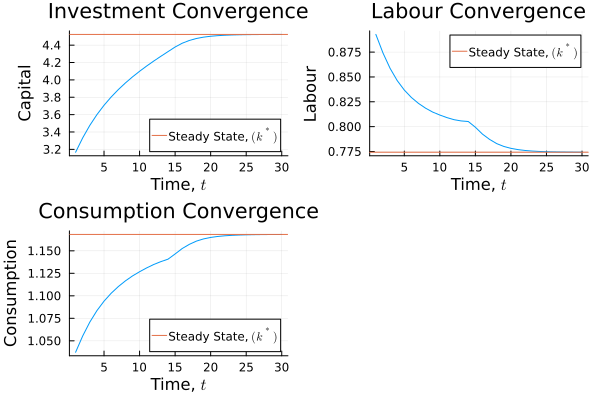

In [136]:
cap_p = plot(K, title="Investment Convergence", xlabel="Time, \$t\$", ylabel="Capital", label = false)
hline!([k_star], label="Steady State, \$(k^*)\$")

lab_p = plot(L, title="Labour Convergence", xlabel="Time, \$t\$", ylabel="Labour", label = false)
hline!([l_star], label="Steady State, \$(k^*)\$")

con_p = plot(C, title="Consumption Convergence", xlabel="Time, \$t\$", ylabel="Consumption", label = false)
hline!([c_star], label="Steady State, \$(k^*)\$")

plot(cap_p, lab_p, con_p, legend=true)

If we had got the cubic splines to work, I would expect this to be smoother again too. However, the general essence of the convergence towards the respective steady states after a certain period of time is what we would expect to see. Especially the direction in which they tend, with capital and consumption beginning at lower levels (and labour beginning at a higher level), tending up (down) towards their steady states.

I do not think that there should be a kink there either.

## Exercise 2
### Exercise 2a

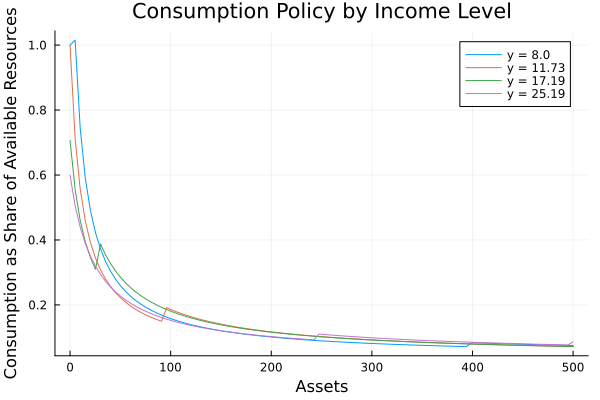

Converged in 491 iterations


In [14]:
using QuantEcon, Optim, Plots, Distributions

# Define parameters
β = 0.95
r = 0.04
ρ = 0.8
σ_ε = 0.1
a_min = 0
a_max = 500
num_a = 100
y_grid_size = 20
σ_crra = 2
τa = 0
τy = 0

# Utility function
u(c) = c > 0 ? c^(1 - σ_crra) / (1 - σ_crra) : -Inf

# Asset grid
a_grid = LinRange(a_min, a_max, num_a)

# Income grid and transition matrix using Rouwenhorst method
mc = rouwenhorst(y_grid_size, ρ, σ_ε, 0.5)
y_grid = mc.state_values
P = mc.p

# Initial guess for the value function
V = zeros(num_a, y_grid_size)
V_new = similar(V)

# Policy functions for consumption and savings
policy_c = zeros(num_a, y_grid_size)
policy_s = zeros(num_a, y_grid_size)

# Bellman operator
function bellman_operator(V, a_grid, y_grid, P, β, r, u)
    for iy in 1:y_grid_size
        for ia in 1:num_a
            val_max = -Inf
            a = a_grid[ia]
            for ja in 1:num_a
                c = a * (1 + r) + exp(y_grid[iy]) - a_grid[ja] - τa * a_grid[ia] - τy * exp(y_grid[iy])
                if c <= 0
                    break
                end
                val = u(c) + β * dot(P[iy, :], V[ja, :])
                if val > val_max
                    val_max = val
                    policy_c[ia, iy] = c
                    policy_s[ia, iy] = a_grid[ja]
                end
            end
            V_new[ia, iy] = val_max
        end
    end
    return V_new
end

# Value function iteration
iter = 0
tol = 1e-12
max_iter = 1000
while iter < max_iter
    V_new = bellman_operator(V, a_grid, y_grid, P, β, r, u)
    if norm(V_new - V, Inf) < tol
        println("Converged in $iter iterations")
        break
    end
    V = copy(V_new)
    iter += 1
end

# Define y indices to plot
yvals = round.(Int, collect(1:4) .* length(y_grid) / 4)

# Initialize the plot variable
p = plot()

# Loop over y indices
for iy in yvals
    plot!(p, a_grid, policy_c[:, iy] ./ (a_grid .+ exp(y_grid[iy]) .+ 1e-10), label="y = $(round(exp(y_grid[iy]), digits=2))")
end

# Set labels and title
xlabel!(p, "Assets")
ylabel!(p, "Consumption as Share of Available Resources")
title!(p, "Consumption Policy by Income Level")
legend=:topright

# Display plot
display(p)

For all income levels, the share of resources consumed is higher when assets are low which is consistent with consumption smoothing behaviour. The consumption policies for different income levels converge as the asset level increases which suggests that the income effect on the consumption share diminishes with higher asset levels. This means that once individuals have sufficient assets, their consumption decisions become less sensitive to their income level. In additionn, as income increases, the consumption share decreases which suggests that individuals with higher incomes tend to save more which is reflected in a lower consumption share at any given asset level.

### Exercise 2b

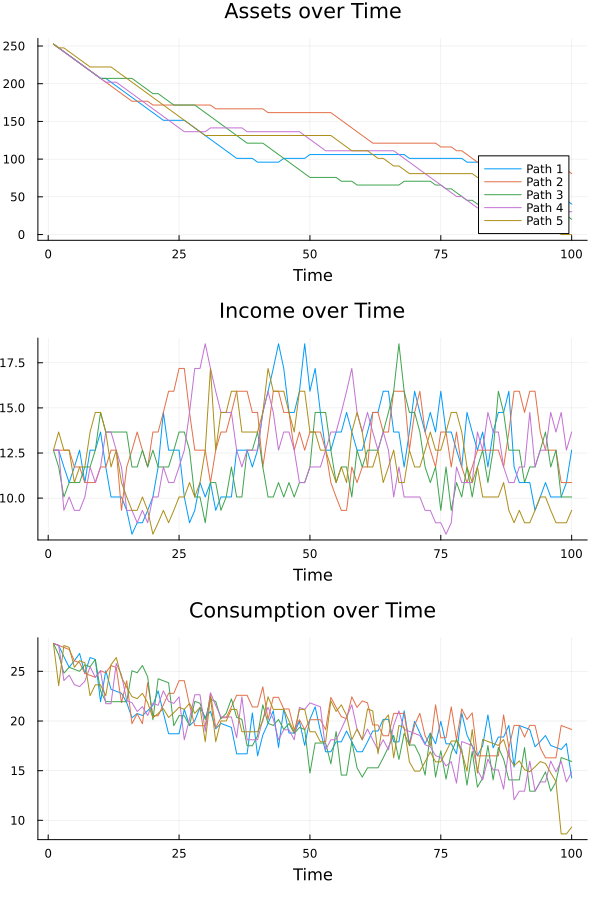

In [15]:
function simulate_path(a_grid, y_grid, policy_c, policy_s, P, a0, y0_idx, T=100)
    path_a = zeros(T)
    path_y = zeros(T)
    path_c = zeros(T)
    
    current_a_idx = findfirst(≥(a0), a_grid)
    current_y_idx = y0_idx
    
    for t in 1:T
        # Ensure we don't index with `nothing`
        current_a_idx = max(current_a_idx, 1)
        current_y_idx = max(current_y_idx, 1)
        
        path_a[t] = a_grid[current_a_idx]
        path_y[t] = exp(y_grid[current_y_idx])  # Convert log income to level
        path_c[t] = policy_c[current_a_idx, current_y_idx]
        
        # Calculate next period's assets
        next_a = policy_s[current_a_idx, current_y_idx]
        current_a_idx = findfirst(≥(next_a), a_grid)
        
        # Simulate next period's income state
        cdf = cumsum(P[current_y_idx, :])
        random_draw = rand()
        next_y_idx = findfirst(x -> x ≥ random_draw, cdf)
        current_y_idx = isnothing(next_y_idx) ? length(y_grid) : next_y_idx
    end
    
    return path_a, path_y, path_c
end

# Initialization for simulation
a0 = median(a_grid)
y0_idx = findfirst(y -> y ≥ median(y_grid), y_grid)

# Simulate and plot paths
num_paths = 5
T = 100

fig = plot(layout = (3, 1), size = (600, 900))

for path_num in 1:num_paths
    path_a, path_y, path_c = simulate_path(a_grid, y_grid, policy_c, policy_s, P, a0, y0_idx, T)
    
    plot!(fig, 1:T, path_a, label = "Path $(path_num)", subplot = 1)
    plot!(fig, 1:T, path_y, label = "Path $(path_num)", subplot = 2)
    plot!(fig, 1:T, path_c, label = "Path $(path_num)", subplot = 3)
end

plot!(fig, title = "Assets over Time", legend = :bottomright, subplot = 1)
plot!(fig, title = "Income over Time", legend = false, subplot = 2)
plot!(fig, title = "Consumption over Time", legend = false, subplot = 3)

xlabel!(fig, "Time", subplot = 1)
xlabel!(fig, "Time", subplot = 2)
xlabel!(fig, "Time", subplot = 3)

display(fig)

Our first graph of assets over time shows a downward trend which indicates that agents are decumulating their assets over the 100 periods. This is due to the fact that consumption is higher than income thus meaning agents are having to utilise their assets to pay for their consumption. The second graph shows income fluctuating over time for each of the paths and doesn't have a clear trend thus aligning with the idea that income follows a stochastic process. Finally, the third graph shows consumption levels on a general downward trend over time which indicates a decrease in resources.

### Exercise 2c

  0.193654 seconds (374.25 k allocations: 31.564 MiB, 7.82% gc time, 88.70% compilation time: 95% of which was recompilation)
  0.013704 seconds (49.16 k allocations: 12.138 MiB, 68.58% gc time)
  0.004586 seconds (65.53 k allocations: 15.790 MiB)
  0.008568 seconds (81.91 k allocations: 20.992 MiB)
  0.012575 seconds (98.29 k allocations: 24.644 MiB, 36.93% gc time)
  0.008976 seconds (114.66 k allocations: 28.297 MiB)
  0.014743 seconds (131.04 k allocations: 31.949 MiB, 15.49% gc time)
  0.011065 seconds (147.41 k allocations: 35.602 MiB)
  0.012364 seconds (163.79 k allocations: 42.497 MiB)
  0.014221 seconds (180.16 k allocations: 46.149 MiB, 9.35% gc time)
  0.014121 seconds (196.54 k allocations: 49.802 MiB, 5.40% gc time)
  0.015282 seconds (212.91 k allocations: 53.454 MiB, 5.88% gc time)
  0.016857 seconds (229.29 k allocations: 57.107 MiB, 8.78% gc time)
  0.017779 seconds (245.66 k allocations: 60.759 MiB, 8.54% gc time)
  0.018424 seconds (262.04 k allocations: 64.412 MiB,

┌ Info: Saved animation to /Users/arthurjohnson/Desktop/PNM for Economics/PNM_for_Econ_Group_1_Desktop/animation.gif
└ @ Plots /Users/arthurjohnson/.julia/packages/Plots/sxUvK/src/animation.jl:156


Plots.AnimatedGif("/Users/arthurjohnson/Desktop/PNM for Economics/PNM_for_Econ_Group_1_Desktop/animation.gif")
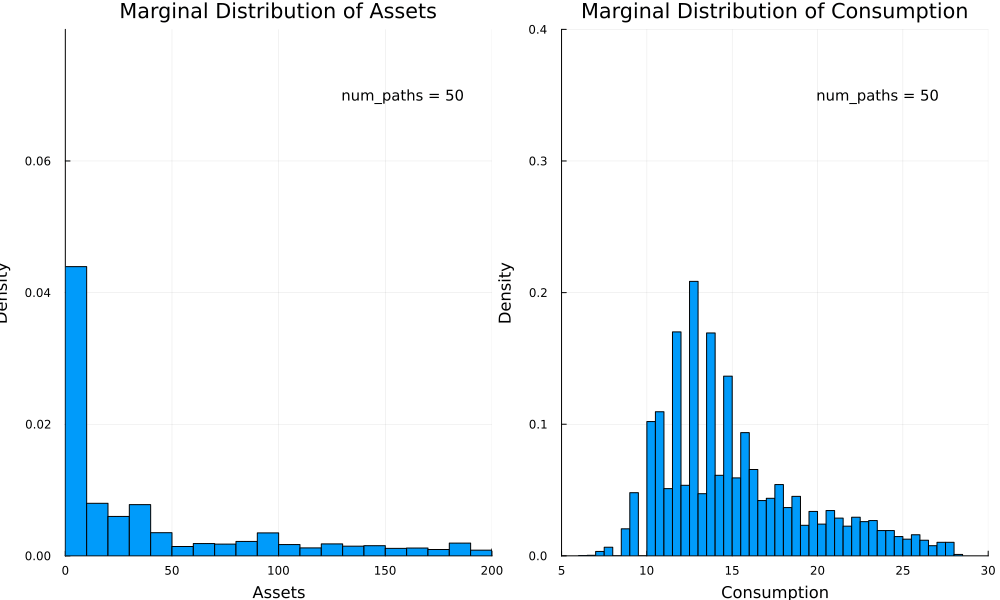

In [16]:
using Plots

anim = @animate for num_paths in range(50, step=25, stop=2000)
    @time begin
        T = 300
        df = DataFrame(a = Float64[], y = Float64[], c = Float64[])
        
        for path_num in 1:num_paths
            path_a, path_y, path_c = simulate_path(a_grid, y_grid, policy_c, policy_s, P, a0, y0_idx, T)
            append!(df, DataFrame(a = path_a, y = path_y, c = path_c))
        end
    end

    plt1 = histogram(df.a,
        xlabel = "Assets",
        ylabel = "Density",
        normed = true,
        title  = "Marginal Distribution of Assets",
        label  = "",
        xlims = (0, 200),
        ylims = (0, 0.08)
    )

    plt2 = histogram(df.c,
        xlabel = "Consumption",
        ylabel = "Density",
        normed = true,
        title  = "Marginal Distribution of Consumption",
        label  = "",
        xlims = (5, 30),
        ylims = (0, 0.4)
    )

    annotate!(plt1, [(130, 0.07, text("num_paths = $num_paths", 10, :left))])
    annotate!(plt2, [(20, 0.35, text("num_paths = $num_paths", 10, :left))])

    plot(plt1, plt2, size = (1000, 600))
end

gif(anim, "animation.gif", fps = 4)

It appears as if for marginal distribution of consumption, we get an approximately normal distribution with a fat right tail. This means there is a higher probability of extreme outliers on the right hand side. 

### Exercise 2d

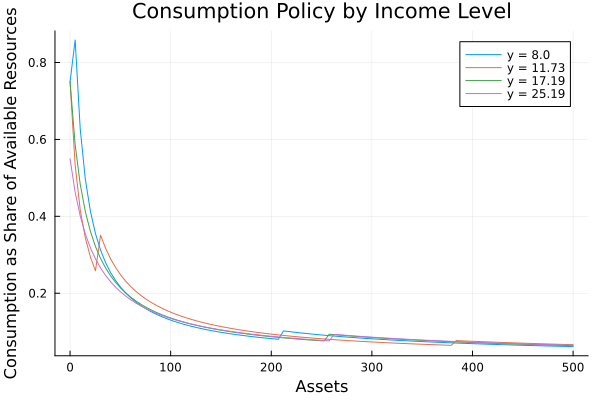

Converged in 469 iterations


In [17]:
τa = 0.25
τy = 0.25
#Calculate Policy Functions
policy_c = zeros(num_a, y_grid_size)
policy_s = zeros(num_a, y_grid_size)

# Bellman operator
function bellman_operator(V, a_grid, y_grid, P, β, r, u)
    for iy in 1:y_grid_size
        for ia in 1:num_a
            val_max = -Inf
            a = a_grid[ia]
            for ja in 1:num_a
                c = a * (1 + r) + exp(y_grid[iy]) - a_grid[ja] - τa * a*r - τy * exp(y_grid[iy])
                if c <= 0
                    break
                end
                val = u(c) + β * dot(P[iy, :], V[ja, :])
                if val > val_max
                    val_max = val
                    policy_c[ia, iy] = c
                    policy_s[ia, iy] = a_grid[ja]
                end
            end
            V_new[ia, iy] = val_max
        end
    end
    return V_new
end

# Value function iteration
iter = 0
tol = 1e-12
max_iter = 1000
while iter < max_iter
    V_new = bellman_operator(V, a_grid, y_grid, P, β, r, u)
    if norm(V_new - V, Inf) < tol
        println("Converged in $iter iterations")
        break
    end
    V = copy(V_new)
    iter += 1
end

# Define y indices to plot
yvals = round.(Int, collect(1:4) .* length(y_grid) / 4)

# Initialize the plot variable
p = plot()

# Loop over y indices
for iy in yvals
    plot!(p, a_grid, policy_c[:, iy] ./ (a_grid .+ exp(y_grid[iy]) .+ 1e-10), label="y = $(round(exp(y_grid[iy]), digits=2))")
end

# Set labels and title
xlabel!(p, "Assets")
ylabel!(p, "Consumption as Share of Available Resources")
title!(p, "Consumption Policy by Income Level")
legend=:topright

# Display plot
display(p)

Tax revenue: 3.367869555688486
Tax as a proportion of income: 0.27177823852559563


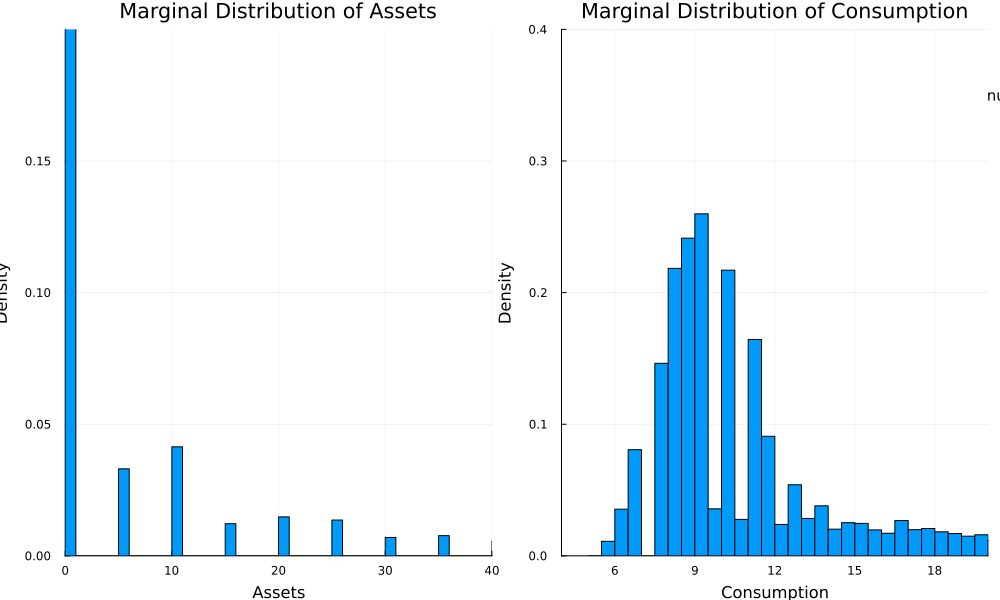

In [18]:
using Plots

num_paths = 50
T = 300
df = DataFrame(a = Float64[], y = Float64[], c = Float64[])

for path_num in 1:num_paths
    path_a, path_y, path_c = simulate_path(a_grid, y_grid, policy_c, policy_s, P, a0, y0_idx, T)
    append!(df, DataFrame(a = path_a, y = path_y, c = path_c))
end

# Calculate tax revenue
tax_revenue = mean(df.a)* τa * r + mean(df.y)* τy
total_income = (tax_revenue)/(mean(df.y))
println("Tax revenue: $tax_revenue")
println("Tax as a proportion of income: $total_income")

plt1 = histogram(df.a,
    xlabel = "Assets",
    ylabel = "Density",
    normed = true,
    title  = "Marginal Distribution of Assets",
    label  = "",
    xlims = (0, 40),  # Set x limits
    ylims = (0, 0.2) # Set y limits
)

plt2 = histogram(df.c,
    xlabel = "Consumption",
    ylabel = "Density",
    normed = true,
    title  = "Marginal Distribution of Consumption",
    label  = "",
    xlims = (4, 20),  # Set x limits
    ylims = (0, 0.4) # Set y limits
)

annotate!(plt1, [(130, 0.07, text("num_paths = $num_paths", 10, :left))])
annotate!(plt2, [(20, 0.35, text("num_paths = $num_paths", 10, :left))])

plot(plt1, plt2, size = (1000, 600))

Adding tax into the model means that it is harder to increase an individual's assets meaning that the percentage of the population without any assets is even higher. However, the distribution of consumption remains largely the same but follows more closely to a normal distribution graph. 